## Clustering tecniques

### Time to get your hands dirty! Fun with Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import requests

from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

# Dataset exploration

I define a function to plot the KDE estimation:

In [2]:
def KDE_plot (X, widths):
    
    X = np.sort(X)
    X = X[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth = widths ) # Gaussian kernel
    kde.fit(X) 
    log_pdf = kde.score_samples(X) # log-pdf of the samples
    distribution = np.exp(log_pdf)
    plt.plot(X, distribution, label = str(widths), lw = 2, c = 'darkorange')
    plt.legend()

Downloading and reading the data, then I do a quick exploration of interesting quantities

In [3]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
dataset = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(np.shape(dataset))

(15, 8485)


In [4]:
Data = {names[i] : dataset[i,:] for i in range(len(names))} # data dictionary

# some check of the shapes 
print(names)
print(Data['T90'])
print(np.shape(Data['GRB_name']), '\n')

# Array format and data cleaning
Data['T90'] = np.array(Data['T90'], dtype = float)
T90_clean = Data['T90'][np.where(Data['T90'] != -999.)[0]] # Gives the index where the condition is true
print(len(T90_clean))

Data["'T100'"] = np.array(Data["'T100'"], dtype = float)
T100_clean = Data["'T100'"][np.where(Data["'T100'"] != -999.)[0]]
print(len(T100_clean))

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']
['-999' '-999' '-999' ... '3.1360' '208.5760' '5.1840']
(8485,) 

7415
7415


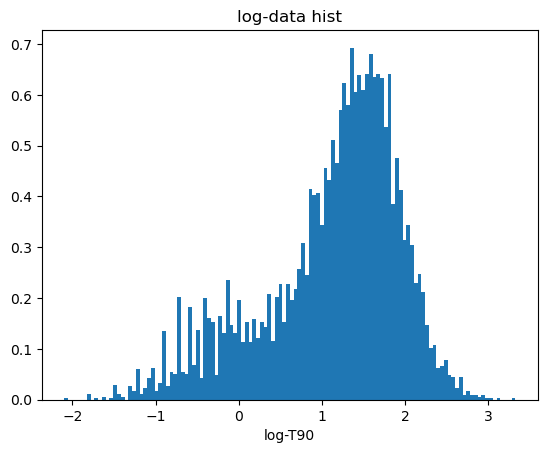

In [5]:
# This histogram is the same, but with the standard data and log-scale binning
#plt.hist(T90_clean, bins = np.logspace(-3,3, num = 100))

log_T90_clean = np.log10(T90_clean)
plt.hist(log_T90_clean, bins = 120, density = True)
plt.title('log-data hist')
plt.xlabel('log-T90')
plt.show()

First thing to do: cross validation to pick the right width for KDE.
In this case, I use a K fold cross validation with the GridSearch from sklearn. I mix the data before CV

Best width:  0.11102040816326529


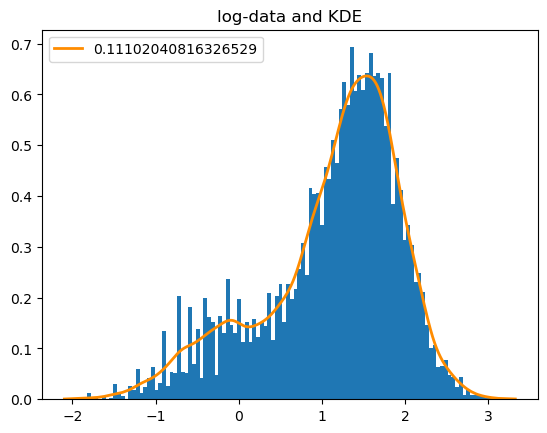

In [6]:
wrange = np.linspace(0.01, 1., 50)
log_T90_clean = shuffle(log_T90_clean)
K_folds = 3  # You can do more

GS = GridSearchCV(KernelDensity(), {'bandwidth': wrange}, cv = K_folds)  
GS.fit(log_T90_clean[:, np.newaxis])  # Fitting with the data 
best_width = GS.best_params_['bandwidth']  # Taking the best value from the fit
print('Best width: ', best_width)

# Using the best value, let's plot the histogram with the optimized KDE
KDE_plot(log_T90_clean, best_width)
plt.hist(log_T90_clean, bins = 120, density = True)
plt.title('log-data and KDE')
plt.show()

# Clustering methods

The first method I'm gonna use is the Gaussian mixture (from old exercise...).
I should CV the number of components for this method. I use a Gridshearch, but I show that also an AIC/BIC analysis is sufficent

Number of components: 2  AIC = 16561.26
Number of components: 2  BIC = 16595.82


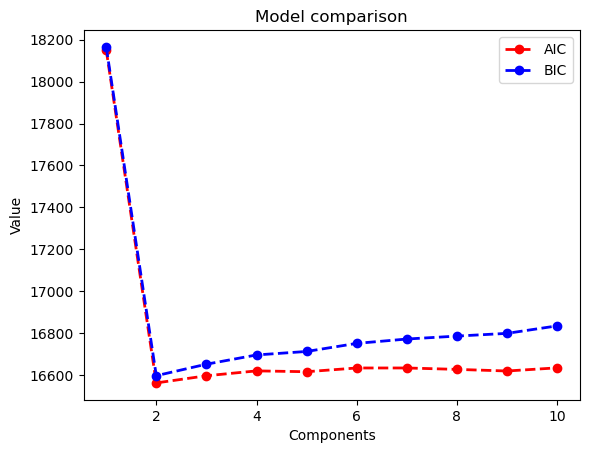

In [7]:
N = 10
AIC = []
BIC = []
gm = []
x = np.arange(1, 11, 1)
#x_grid = np.linspace(np.min(log_T90_clean), np.max(log_T90_clean), len(log_T90_clean))

# Training the various models on the data and stack them in an array
for i in range(1, N+1):
    
    gm.append(GaussianMixture(n_components = i, random_state = 0, init_params = 'kmeans').fit(log_T90_clean[:, np.newaxis]))
    
    AIC.append(gm[i-1].aic(log_T90_clean[:, np.newaxis]))
    BIC.append(gm[i-1].bic(log_T90_clean[:, np.newaxis]))
    
# Computing the best model: the one for which the AIC (or BIC) is minimum
min_aic = np.argmin(AIC)
min_bic = np.argmin(BIC)

print('Number of components:',min_aic + 1, ' AIC = %.02f' %AIC[min_aic])
print('Number of components:',min_bic + 1, ' BIC = %.02f' %BIC[min_bic])

# Printing the AIC and the BIC, fun to show the plots 
fig = plt.figure()
plt.plot(x, AIC, color='red', lw = 2, marker = 'o', ls = '--', label = 'AIC')
plt.plot(x, BIC, color='blue', lw = 2, marker = 'o', ls = '--', label = 'BIC')
plt.title('Model comparison')
plt.xlabel('Components')
plt.ylabel('Value')
plt.legend()
plt.show()


In [8]:
n_comps = np.linspace(1, 8, 8, dtype = int)
log_T90_clean = shuffle(log_T90_clean)
K_folds = 5  # You can do more

GS = GridSearchCV(GaussianMixture(), {'n_components': n_comps}, cv = K_folds)  
GS.fit(log_T90_clean[:, np.newaxis])  # Fitting with the data 
best_comps = GS.best_params_['n_components']  # Taking the best value from the fit
print('Best n_comps: ', best_comps)

Best n_comps:  2


Distribution centers:  [1.48652667] [-0.03249599]
Distribution widths:  [[0.21305932]] [[0.38337321]]
GRB170817A time:  [0.31132995]


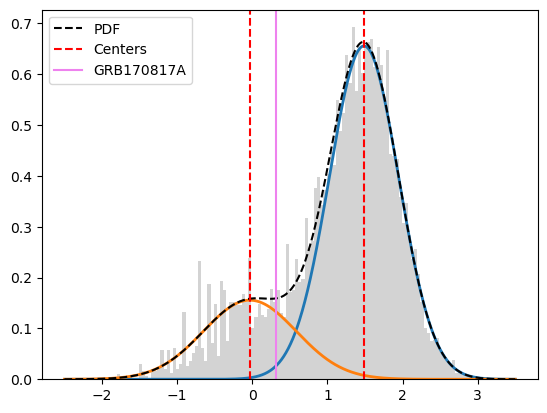

SGRB index:  1
LGRB index:  0


In [9]:
GRB_gauss = GaussianMixture(n_components = best_comps, init_params = 'kmeans')
GRB_gauss.fit(log_T90_clean[:, np.newaxis])

gauss_means = GRB_gauss.means_
gauss_cov = GRB_gauss.covariances_

print('Distribution centers: ', gauss_means[0], gauss_means[1])
print('Distribution widths: ', gauss_cov[0], gauss_cov[1])

# The training is done, now we can use it to plot the model
x_grid = np.linspace(-2.5, 3.5, 1000)

gauss_dist = np.exp(GRB_gauss.score_samples(x_grid[:, np.newaxis]))
responsibilities = GRB_gauss.predict_proba(x_grid[:, np.newaxis])
single_dist = gauss_dist[:, np.newaxis] * responsibilities

# Funny: GW170817 NS merger in GRB data!
GRB_index = np.where(Data['GRB_name'] == 'GRB170817A')[0]
print('GRB170817A time: ', np.log10(Data['T90'][GRB_index]))

plt.plot(x_grid, single_dist[:, 0], lw = 2)
plt.plot(x_grid, single_dist[:, 1], lw = 2)
plt.plot(x_grid, gauss_dist, ls = '--', c = 'black', label = 'PDF')
plt.axvline(gauss_means[0], c = 'red', ls = '--', label = 'Centers')
plt.axvline(gauss_means[1], c = 'red', ls = '--')
plt.axvline(np.log10(Data['T90'][GRB_index]), c = 'violet', label = 'GRB170817A')
plt.hist(log_T90_clean[:, np.newaxis], bins = 130, density = True, color = 'lightgray')
plt.legend()
plt.show()

if gauss_means[0] > gauss_means[1]:
    LGRB = 0
    SGRB = 1
else:
    LGRB = 1
    SGRB = 0

print('SGRB index: ', SGRB)
print('LGRB index: ', LGRB)

This is the prediction of the GW170817 event, that is a SGB with a duration of almost half a second as expected

In [10]:
print('GW170817A is: ', GRB_gauss.predict(log_T90_clean[GRB_index][:, np.newaxis]))
print('Distribution centers: ', gauss_means[SGRB], gauss_means[LGRB])

GW170817A is:  [1]
Distribution centers:  [-0.03249599] [1.48652667]


Classification with the K-means, I assume also here two components. In principle I should do a new CV similar to the one in **Handwritten digits** exercise.

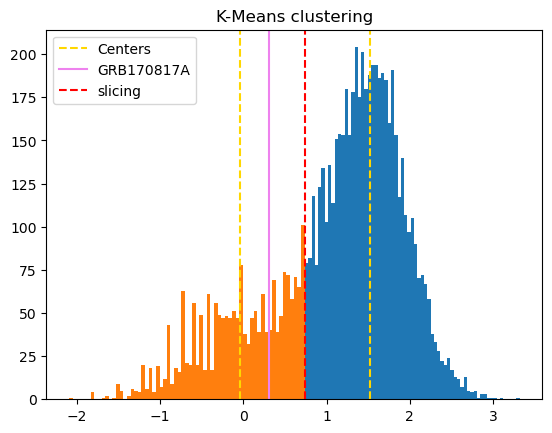

Switch duration time of GRB with KM: 5.47s
Cluster centers:  [-0.04241508] [1.52215247]


In [11]:
# K-Means algorithm
GRB_class = KMeans(n_clusters = 2)
GRB_class.fit(log_T90_clean[:, np.newaxis])
cluster_centers = GRB_class.cluster_centers_
labels = GRB_class.predict(log_T90_clean[:, np.newaxis])

# Fixing the labels
if cluster_centers[SGRB] > cluster_centers[LGRB]: 
    labels[labels == SGRB] = 2
    labels[labels == LGRB] = SGRB
    labels[labels == 2] = LGRB

    # swapping the centers
    c1 = cluster_centers[SGRB].copy()
    c2 = cluster_centers[LGRB].copy()
    cluster_centers[SGRB] = c2
    cluster_centers[LGRB] = c1

edge = np.mean( [max(log_T90_clean[labels == SGRB]), min(log_T90_clean[labels == LGRB])]) 

for i in range(2):
    plt.hist(log_T90_clean[labels == i], bins = 65)

plt.axvline(cluster_centers[LGRB], c = 'gold', ls = '--', label = 'Centers')
plt.axvline(cluster_centers[SGRB], c = 'gold', ls = '--')
plt.axvline(np.log10(Data['T90'][GRB_index]), c = 'violet', label = 'GRB170817A')
plt.axvline(edge, ls = '--', c = 'red', label = 'slicing')
plt.title('K-Means clustering')
plt.legend()
plt.show()

print('Switch duration time of GRB with KM: %.02f' %10**edge + 's')
print('Cluster centers: ', cluster_centers[SGRB], cluster_centers[LGRB])

# Comparisons

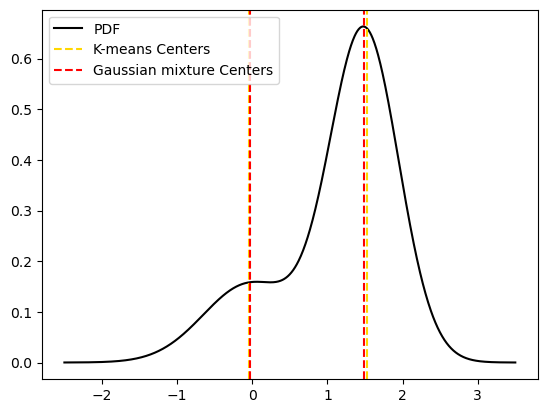

Relative difference between the centers of SGRB:  [0.0225807]
Relative difference between the centers of LGRB:  [0.08548995]


In [12]:
# some comparison

plt.plot(x_grid, gauss_dist, c = 'black', label = 'PDF')
plt.axvline(cluster_centers[0], c = 'gold', ls = '--', label = 'K-means Centers')
plt.axvline(cluster_centers[1], c = 'gold', ls = '--')
plt.axvline(gauss_means[0], c = 'red', ls = '--', label = 'Gaussian mixture Centers')
plt.axvline(gauss_means[1], c = 'red', ls = '--')
plt.legend()
plt.show()

# the order of magnitude of the maximum is not too different: I take the maximum from gauss mixture
# to compute the relative shift
print('Relative difference between the centers of SGRB: ', np.abs((10**gauss_means[SGRB] - 10**cluster_centers[SGRB])/10**gauss_means[SGRB])) 
print('Relative difference between the centers of LGRB: ', np.abs((10**gauss_means[LGRB] - 10**cluster_centers[LGRB])/10**gauss_means[LGRB])) 


I can plot a confusion matrix to show the difference between the two clustering techniques. The values in the top right corener are values for which the probability to be SGRB is larger than the probability of LGRB in the GMM, but the K-mean classifies them as LGRB.

In [13]:
print('SGRB index: ', SGRB)
print('LGRB index: ', LGRB, '\n')

GM_pred = GRB_gauss.predict(log_T90_clean[:, np.newaxis])
K_means_pred = GRB_class.predict(log_T90_clean[:, np.newaxis])
print(skm.confusion_matrix(GM_pred, K_means_pred))

SGRB index:  1
LGRB index:  0 

[[5512  281]
 [   0 1622]]


## Redshift

Long GRB seems to have slightly higher redshift average, it makes sense 
because long GRB are consequences of SN events, which are easier to observe
and are generally related to younger stars than short GRB from NS mergers

Text(0, 0.5, 'z')

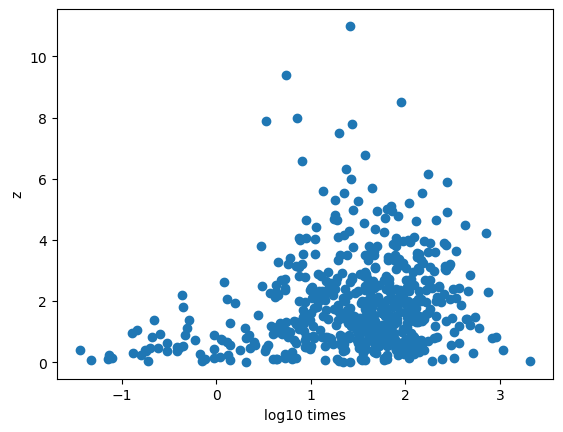

In [18]:


Data['redshift'] = np.array(Data['redshift'], dtype = float)
redshift = Data['redshift'][np.where(Data['redshift'] != -999.)[0]]

# Filtering to take only the ones with time mesurement
f_redshift, f_T90 = [], []

for i in range(len(Data['redshift'])):
    
    if Data['redshift'][i] != -999. and Data['T90'][i] != -999. :
        f_redshift.append(Data['redshift'][i])
        f_T90.append(Data['T90'][i])
        
f_redshift = np.array(f_redshift)
f_T90 = np.array(np.log10(f_T90))


plt.scatter(f_T90, f_redshift)
plt.xlabel('log10 times')
plt.ylabel('z')

I trained the Gaussian mixture model and K-Means model to recognise GRB, I can compare the results and try something with redshift

In [19]:
labels_f_T90 = GRB_gauss.predict(f_T90[:, np.newaxis])

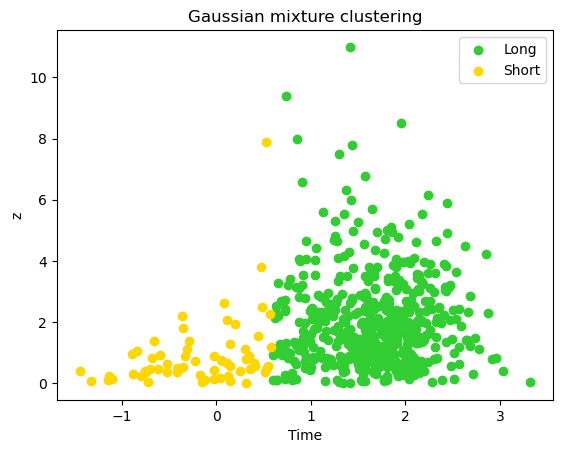

Long GRB redshift average with Gaussian Mixture:  2.022247834645669
Short GRB redshift average with Gaussian Mixture:  0.9133047619047617


In [20]:
plt.scatter(f_T90[labels_f_T90 == LGRB], f_redshift[labels_f_T90 == LGRB], c = 'limegreen', label = 'Long')
plt.scatter(f_T90[labels_f_T90 == SGRB], f_redshift[labels_f_T90 == SGRB], c = 'gold', label = 'Short')
plt.xlabel('Time')
plt.ylabel('z')
plt.title('Gaussian mixture clustering')
plt.legend()
plt.show()

print('Long GRB redshift average with Gaussian Mixture: ', np.mean(f_redshift[labels_f_T90 == LGRB]))
print('Short GRB redshift average with Gaussian Mixture: ', np.mean(f_redshift[labels_f_T90 == SGRB]))


It seems that LGRBs have an higher redshift... I can look for a possible selection bias, because in the dataset there are the fluxes!

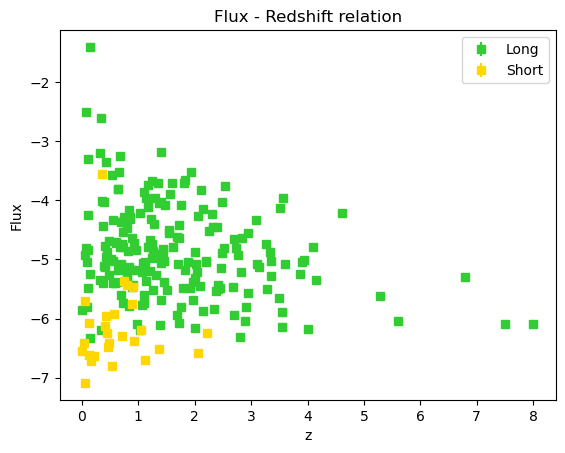

Long GRB flux average with Gaussian Mixture:  0.017339695599295414
Short GRB flux average with Gaussian Mixture:  7.09920122912398e-05


In [29]:
fluxes, fluxes_err, E_redshift, times = [], [], [], []

Data['redshift'] = np.array(Data['redshift'], dtype = float)
Data['fluence'] = np.array(Data['fluence'], dtype = float)
Data['fluence_error'] = np.array(Data['fluence_error'], dtype = float)

# Now classify the fluxes with the labels: which fluxes is from LGRB or SGRB?
# And also take the non null values for each category

for i in range(len(Data['fluence'])):
    
    if Data['fluence'][i] != -999. and Data['fluence_error'][i] != -999. and Data['redshift'][i] != -999. and Data['T90'][i] != -999. :

        fluxes.append(Data['fluence'][i])
        times.append(Data['T90'][i])
        fluxes_err.append(Data['fluence_error'][i])
        E_redshift.append(Data['redshift'][i])


times = np.array(np.log10(times))
fluxes = np.array(fluxes)
fluxes_err = np.array(fluxes_err)
E_redshift = np.array(E_redshift)

labels = GRB_gauss.predict(times[:, np.newaxis])

plt.errorbar(E_redshift[labels == LGRB], np.log10(fluxes[labels == LGRB]), fluxes_err[labels == LGRB], ls = '', marker = 's', c = 'limegreen', label = 'Long')
plt.errorbar(E_redshift[labels == SGRB], np.log10(fluxes[labels == SGRB]), fluxes_err[labels == SGRB], ls = '', marker = 's', c = 'gold', label = 'Short')
plt.xlabel('z')
plt.ylabel('Flux')
plt.title('Flux - Redshift relation')
plt.legend()
plt.show()


print('Long GRB flux average with Gaussian Mixture: ', np.average(fluxes[labels == LGRB], weights = fluxes_err[labels == LGRB]) )
print('Short GRB flux average with Gaussian Mixture: ', np.average(fluxes[labels == SGRB], weights = fluxes_err[labels == SGRB]) )


The mean fluxes of LGRB are higher than the mean fluxes of SGRB for the same redshift: this means that probably the redshift distribution is a consequence of a selection effect on the SGRB, that are intrinsecally fainter.